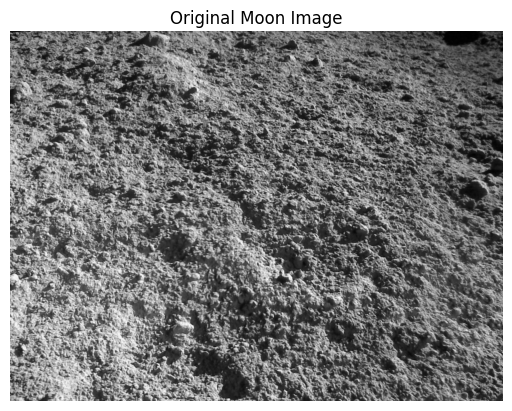

In [1]:
import cv2
import matplotlib.pyplot as plt

# Load the grayscale image

img = cv2.imread("/Users/vithikasurve/Desktop/Image Processing/LunaShape/data/rim/data/calibrated/20230830/ch3_rim_nc1_20230830T1931272059_d_img_d32_2_0.jpg", cv2.IMREAD_GRAYSCALE)

# Display it
plt.imshow(img, cmap='gray')
plt.title("Original Moon Image")
plt.axis('off')
plt.show()



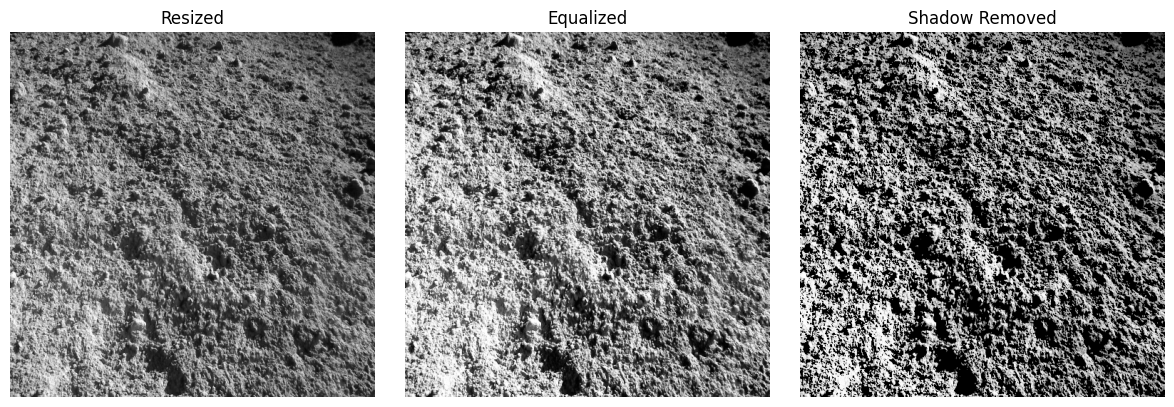

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# === Load your lunar image ===
# Make sure the image is in the same directory or give full path
img = cv2.imread("/Users/vithikasurve/Desktop/Image Processing/LunaShape/data/rim/data/calibrated/20230830/ch3_rim_nc1_20230830T1931272059_d_img_d32_2_0.jpg", cv2.IMREAD_GRAYSCALE)


# === Step 1: Resize ===
img_resized = cv2.resize(img, (512, 512))  # Resize to 512x512

# === Step 2: Normalize [0, 1] ===
img_norm = img_resized / 255.0

# === Step 3: Histogram Equalization ===
img_eq = cv2.equalizeHist((img_norm * 255).astype(np.uint8))

# === Step 4: Shadow Removal ===
# Using adaptive threshold to generate a shadow mask
shadow_mask = cv2.adaptiveThreshold(
    img_eq,                # Input image
    255,                   # Max value
    cv2.ADAPTIVE_THRESH_MEAN_C,  # Adaptive method
    cv2.THRESH_BINARY,     # Threshold type
    35,                    # Block size
    10                     # Constant subtracted
)

# Apply mask to the image to remove shadows
img_shadow_removed = cv2.bitwise_and(img_eq, img_eq, mask=shadow_mask)

# === Step 5: Display results ===
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Resized")
plt.imshow(img_resized, cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Equalized")
plt.imshow(img_eq, cmap='gray')
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Shadow Removed")
plt.imshow(img_shadow_removed, cmap='gray')
plt.axis("off")

plt.tight_layout()
plt.show()

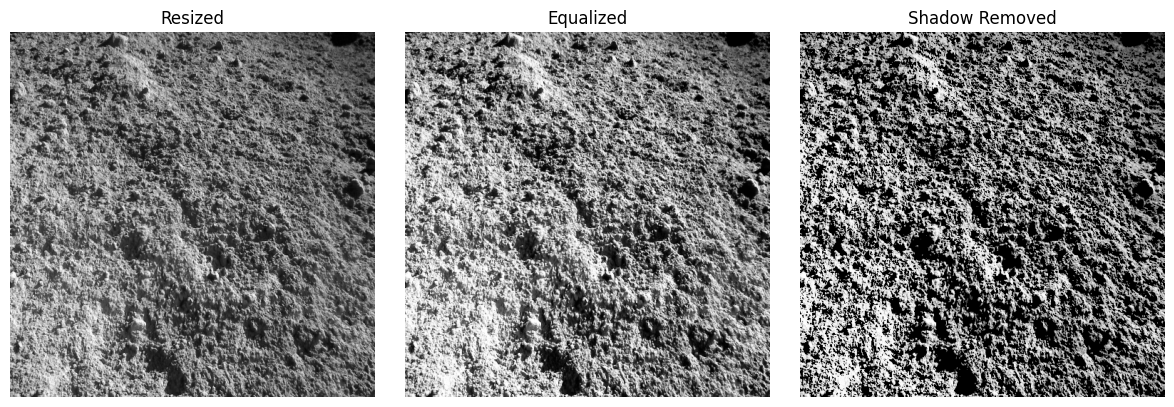

True

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# === Load Your Image ===
img = cv2.imread("/Users/vithikasurve/Desktop/Image Processing/LunaShape/data/rim/data/calibrated/20230830/ch3_rim_nc1_20230830T1931272059_d_img_d32_2_0.jpg", cv2.IMREAD_GRAYSCALE)  # Update to your actual file
img_resized = cv2.resize(img, (512, 512))

# === Normalize ===
img_norm = img_resized / 255.0

# === Histogram Equalization ===
img_eq = cv2.equalizeHist((img_norm * 255).astype(np.uint8))

# === Shadow Removal (optional - crude) ===
shadow_mask = cv2.adaptiveThreshold(
    img_eq, 255,
    cv2.ADAPTIVE_THRESH_MEAN_C,
    cv2.THRESH_BINARY, 35, 10
)
img_shadow_removed = cv2.bitwise_and(img_eq, img_eq, mask=shadow_mask)

# === Output for next steps ===
processed = img_shadow_removed

# === Display ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1); plt.title("Resized"); plt.imshow(img_resized, cmap='gray'); plt.axis("off")
plt.subplot(1, 3, 2); plt.title("Equalized"); plt.imshow(img_eq, cmap='gray'); plt.axis("off")
plt.subplot(1, 3, 3); plt.title("Shadow Removed"); plt.imshow(processed, cmap='gray'); plt.axis("off")
plt.tight_layout(); plt.show()

# === Save Processed Image (Optional but useful) ===
cv2.imwrite("processed_output_vith.png", processed)

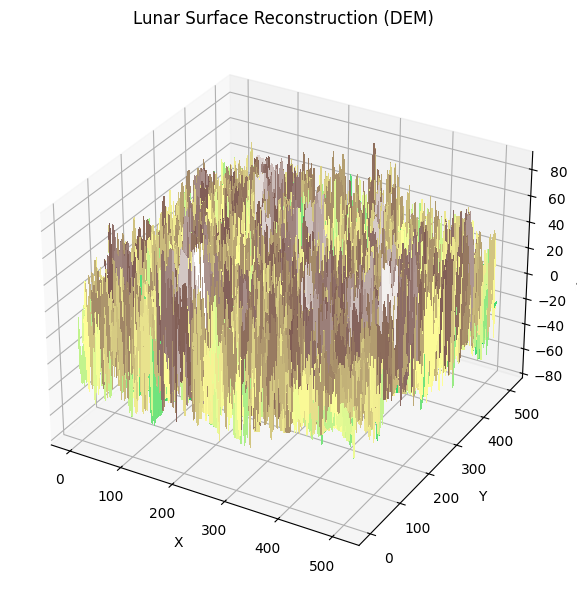

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from mpl_toolkits.mplot3d import Axes3D

# === Step 0: Load Your Preprocessed Image ===
img = cv2.imread("/Users/vithikasurve/Desktop/Image Processing/LunaShape/Codes/processed_output_vith.png", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (512, 512))

# === Step 1: Estimate Gradients using Sobel ===
grad_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)  # ∂z/∂x
grad_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)  # ∂z/∂y

# Normalize gradients
p = grad_x / 255.0
q = grad_y / 255.0

# === Step 2: Frankot-Chellappa Surface Reconstruction ===
def frankot_chellappa(p, q):
    rows, cols = p.shape
    wx = np.tile(np.fft.fftfreq(cols), (rows, 1))
    wy = np.tile(np.fft.fftfreq(rows), (cols, 1)).T

    Wx = 2 * np.pi * wx
    Wy = 2 * np.pi * wy

    denom = Wx**2 + Wy**2
    denom[0, 0] = 1e-6  # avoid divide-by-zero

    Z = (-1j * Wx * fft2(p) - 1j * Wy * fft2(q)) / denom
    z = np.real(ifft2(Z))
    return z

dem = frankot_chellappa(p, q)

# === Step 3: 3D Visualization ===
X, Y = np.meshgrid(np.arange(dem.shape[1]), np.arange(dem.shape[0]))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, dem, cmap='terrain', linewidth=0, antialiased=False)
ax.set_title("Lunar Surface Reconstruction (DEM)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Elevation")

plt.tight_layout()
plt.show()



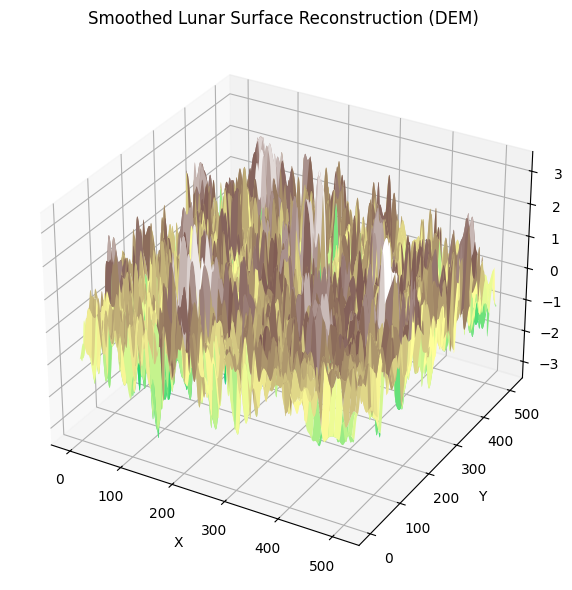

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d import Axes3D

# === Step 0: Load Image ===
img = cv2.imread("/Users/vithikasurve/Desktop/Image Processing/LunaShape/Codes/processed_output_vith.png", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (512, 512))

# === Step 1: Gaussian Blur (Denoising) ===
img_blurred = cv2.GaussianBlur(img, (9, 9), 3)

# === Step 2: Sobel Gradients ===
grad_x = cv2.Scharr(img_blurred, cv2.CV_64F, 1, 0)
grad_y = cv2.Scharr(img_blurred, cv2.CV_64F, 0, 1)

# === Step 3: Normalize Gradients ===
p = grad_x / np.max(np.abs(grad_x))
q = grad_y / np.max(np.abs(grad_y))

# === Step 4: Frankot-Chellappa Integration ===
def frankot_chellappa(p, q):
    rows, cols = p.shape
    wx = np.tile(np.fft.fftfreq(cols), (rows, 1))
    wy = np.tile(np.fft.fftfreq(rows), (cols, 1)).T

    Wx = 2 * np.pi * wx
    Wy = 2 * np.pi * wy

    denom = Wx**2 + Wy**2
    denom[0, 0] = 1e-6  # Avoid divide-by-zero

    Z = (-1j * Wx * fft2(p) - 1j * Wy * fft2(q)) / denom
    z = np.real(ifft2(Z))
    return z

dem = frankot_chellappa(p, q)

# === Step 5: Smooth DEM ===
dem_smooth = gaussian_filter(dem, sigma=3)

# === Step 6: 3D Plot ===
X, Y = np.meshgrid(np.arange(dem.shape[1]), np.arange(dem.shape[0]))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, dem_smooth, cmap='terrain', linewidth=0, antialiased=True)
ax.set_title("Smoothed Lunar Surface Reconstruction (DEM)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Elevation")

plt.tight_layout()
plt.show()